### Damped cubic oscillator

In [1]:
#used for plotting
%pylab inline

#import all necessary libraries
import numpy as np
import tensorflow as tf
from scipy.integrate import odeint

#import utils package
from utils_keras import *

#for reproducibility
np.random.seed(0)

#percent of noise of the data
noise_percent = 10 #for other examples: 0, 1, 5, 25#

Populating the interactive namespace from numpy and matplotlib


##### Generate data

Text(0, 0.5, '$y$')

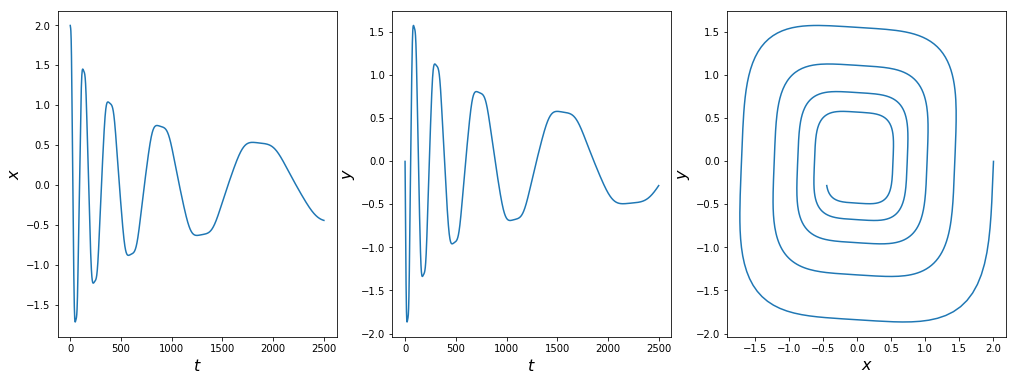

In [2]:
#ODE for damped cubic oscillator
def damped_cubic_osc(X, t):
    #INPUTS:
        #X: 2-dim. array for position
        #t: 1-dim. array for time
    x,y = X
    return [-0.1*x**3 + 2.0*y**3, -2.0*x**3 - 0.1*y**3]

#generate larger set
M = 25000
subsample_rate = 10

#take a subsample of size m = M/subsample_rate
subsample = [j for j in range(M) if j%subsample_rate == 0]

#number of measurements
m = len(subsample) 
#dimension of each measurement and state
n = 2 

#time starting at t=0 up to t=25 with M steps between
t = np.linspace(0,25,M)
#time between each sampling time
dt = ((t[1]-t[0])*subsample_rate).astype('float32')

#integrate system of ODE for damped cubic oscillator, starting at [2,0] with M timesteps; take a subsample of size m
X = odeint(damped_cubic_osc, [2,0], t, rtol = 1e-12, atol = 1e-12)[subsample, :].T

#plot
pylab.rcParams['figure.figsize'] = (17,6)
subplot(1,3,1); plot(X[0,:])
xlabel(r'$t$', fontsize = 16); ylabel(r'$x$', fontsize = 16)
subplot(1,3,2); plot(X[1,:])
xlabel(r'$t$', fontsize = 16); ylabel(r'$y$', fontsize = 16)
subplot(1,3,3); plot(X[0,:],X[1,:])
xlabel(r'$x$', fontsize = 16); ylabel(r'$y$', fontsize = 16)

##### Corrupt measurements with noise

In [3]:
#noise_level = % of noise * standard deviation of X
noise_level = 0.01*noise_percent*np.std(X)
#generate noise for X
measurement_noise = noise_level*np.random.randn(*X.shape)
#Y=X+noise
Y = X + measurement_noise
print(noise_level)

#transpose data for Keras environment
Y = Y.T.astype('float32')
X = X.T

#initial approximation of the noise, see utils package
N_hat, X_hat = approximate_noise(Y, lam = 1e4)

0.06268319041225383


##### Plot data

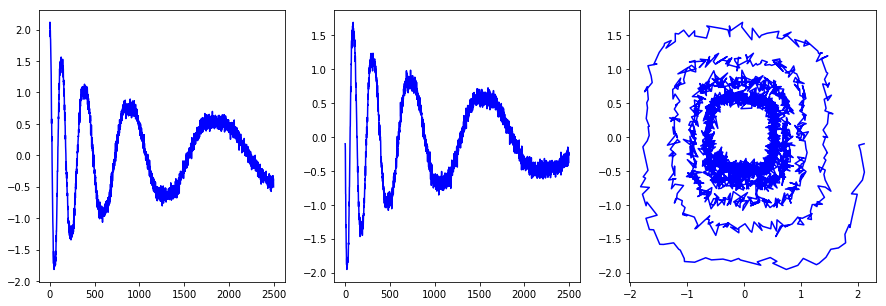

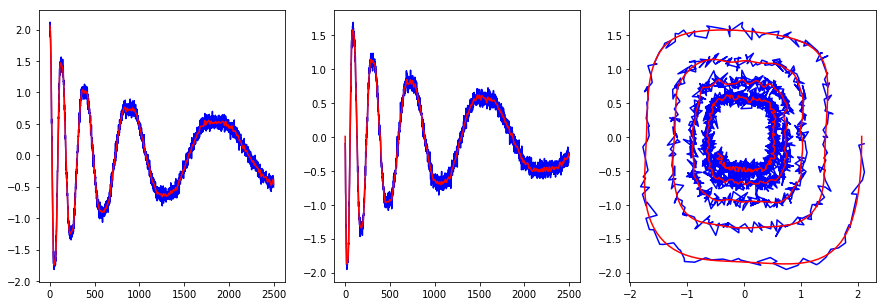

In [4]:
figure(figsize = (15,5))
subplot(1,3,1); plot(Y[:,0], 'b')
subplot(1,3,2); plot(Y[:,1], 'b')
subplot(1,3,3); plot(Y[:,0],Y[:,1], 'b')

figure(figsize = (15,5))
subplot(1,3,1); plot(Y[:,0], 'b'); plot(X_hat[:,0], 'r')
subplot(1,3,2); plot(Y[:,1], 'b'); plot(X_hat[:,1], 'r')
subplot(1,3,3); plot(Y[:,0],Y[:,1], 'b'); plot(X_hat[:,0],X_hat[:,1], 'r')

##### Set up hyperparameters

In [5]:
num_dt = 10 #q
hidden_size = 32 #size of hidden layers
gamma = 1e-4 
beta = 1e-6 
decay_const = 0.9 #constant for exponential decay
number_of_hlayers = 3 #number of hidden layers

##### Train the network

In [6]:
#import Keras libraries
from keras import layers
import keras
import keras.backend as K
from keras.optimizers import Adam

#Clear the default session
K.clear_session()

#construct the network
inputs = keras.Input(shape=(n,))
x = layers.Dense(hidden_size, activation='elu',bias_initializer='zeros', kernel_initializer = keras.initializers.glorot_uniform(seed=1))(inputs)
x = layers.Dense(hidden_size, activation='elu',bias_initializer='zeros', kernel_initializer = keras.initializers.glorot_uniform(seed=1))(x)
x = layers.Dense(hidden_size, activation='elu',bias_initializer='zeros', kernel_initializer = keras.initializers.glorot_uniform(seed=1))(x)
outputs = layers.Dense(n, activation = 'linear',bias_initializer='zeros', kernel_initializer = keras.initializers.glorot_uniform(seed=1))(x)
model = keras.Model(inputs=inputs, outputs=outputs)

#get custom loss function
custom_loss = loss_class(Y, num_dt, np.array([[dt]]), model, gamma, beta, decay_const,N_init = N_hat)

#add estimated errors as trainable parameter
model.layers[-1].trainable_weights.append(custom_loss.N_variable)

#compile the model
model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              loss=custom_loss.loss)

#fit the model
model.fit(X_hat, Y, batch_size=m, epochs=3000, verbose = 0)#verbose = 1 if interested in each epoch

Instructions for updating:
Colocations handled automatically by placer.


Using TensorFlow backend.


Instructions for updating:
Use tf.cast instead.


In [7]:
#check model, trainable parameters and estimated loss for debugging(can be removed)
model.summary()
model.trainable_weights
K.eval(custom_loss.N)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 5066      
Total params: 7,274
Trainable params: 7,274
Non-trainable params: 0
_________________________________________________________________


array([[-0.00612474,  0.05397075],
       [-0.06637781,  0.15511003],
       [-0.03202527,  0.21900645],
       ...,
       [ 0.05876345,  0.03290571],
       [ 0.03133846, -0.00393154],
       [-0.03779255,  0.0036929 ]], dtype=float32)

##### Compute the forward orbit

In [8]:
#testing on true initial condition
X_test = np.zeros((m,n), dtype = 'float32')
X_test[0,:] = X[0,:]

#run the network on last known point, starting at true initial condition; computes forward orbit
for j in range(m-1):
    X_test[j+1,:] = RK_timestepper_keras(np.array([X_test[j,:]]), model.predict,dt)

##### Plot results

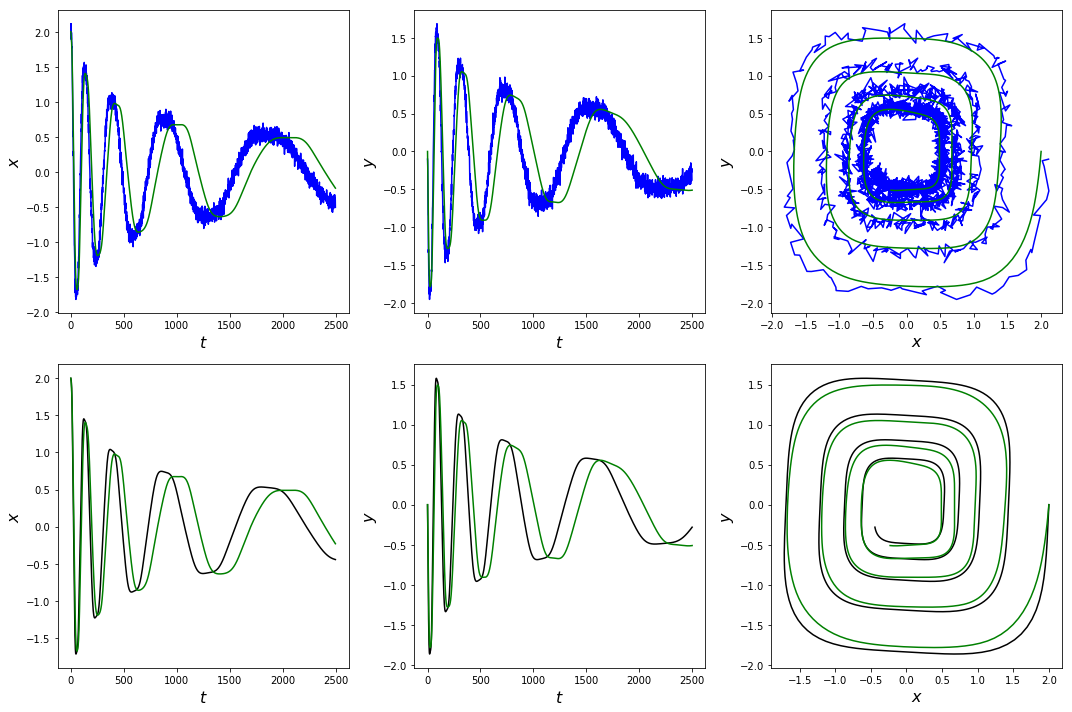

In [9]:
#plot forward orbit
figure(figsize = (15,10))

subplot(2,3,1); plot(Y[:,0], 'b'); plot(X_test[:,0], 'g')
xlabel(r'$t$', fontsize = 16); ylabel(r'$x$', fontsize = 16)
subplot(2,3,2); plot(Y[:,1], 'b'); plot(X_test[:,1], 'g')
xlabel(r'$t$', fontsize = 16); ylabel(r'$y$', fontsize = 16)
subplot(2,3,3); plot(Y[:,0],Y[:,1], 'b'); plot(X_test[:,0],X_test[:,1], 'g')
xlabel(r'$x$', fontsize = 16); ylabel(r'$y$', fontsize = 16)

subplot(2,3,4); plot(X[:,0], 'k'); plot(X_test[:,0], 'g')
xlabel(r'$t$', fontsize = 16); ylabel(r'$x$', fontsize = 16)
subplot(2,3,5); plot(X[:,1], 'k'); plot(X_test[:,1], 'g')
xlabel(r'$t$', fontsize = 16); ylabel(r'$y$', fontsize = 16)
subplot(2,3,6); plot(X[:,0],X[:,1], 'k'); plot(X_test[:,0],X_test[:,1], 'g')
xlabel(r'$x$', fontsize = 16); ylabel(r'$y$', fontsize = 16)

tight_layout()

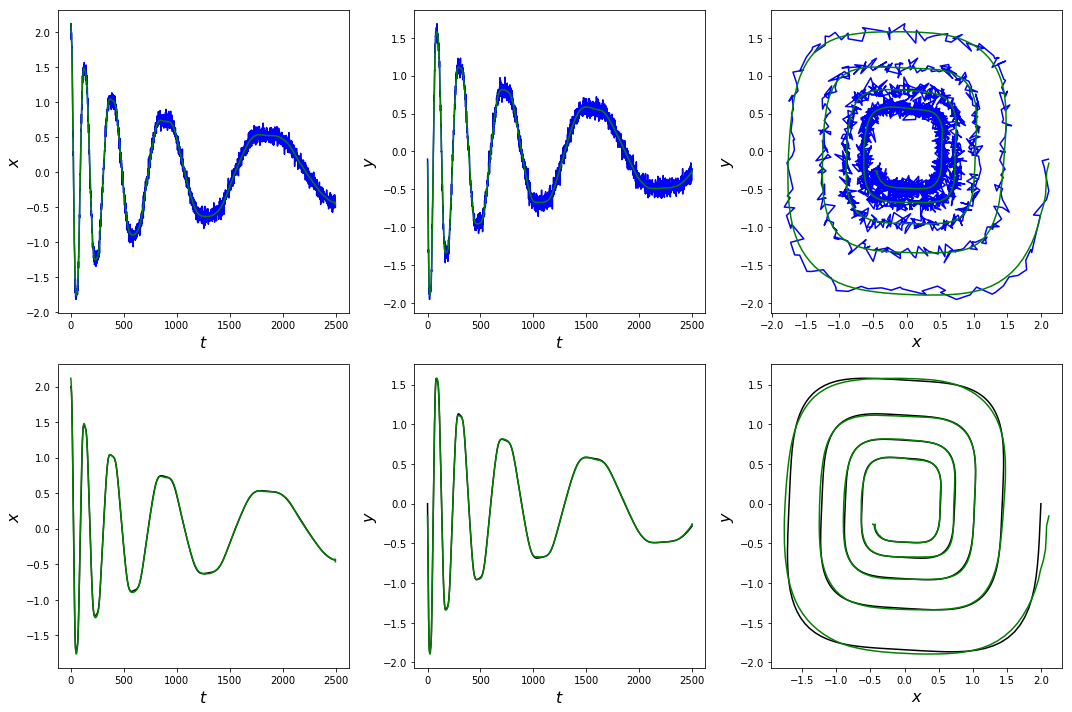

In [10]:
#compute the learned estimates of the given data
X_hat = Y - K.eval(custom_loss.N) #N is a tf variable, so need to use .eval() to make into an array 

#plot
figure(figsize = (15,10))
subplot(2,3,1); plot(Y[:,0], 'b'); plot(X_hat[:,0], 'g')
xlabel(r'$t$', fontsize = 16); ylabel(r'$x$', fontsize = 16)
subplot(2,3,2); plot(Y[:,1], 'b'); plot(X_hat[:,1], 'g')
xlabel(r'$t$', fontsize = 16); ylabel(r'$y$', fontsize = 16)
subplot(2,3,3); plot(Y[:,0],Y[:,1], 'b'); plot(X_hat[:,0],X_hat[:,1], 'g')
xlabel(r'$x$', fontsize = 16); ylabel(r'$y$', fontsize = 16)

subplot(2,3,4); plot(X[:,0], 'k'); plot(X_hat[:,0], 'g')
xlabel(r'$t$', fontsize = 16); ylabel(r'$x$', fontsize = 16)
subplot(2,3,5); plot(X[:,1], 'k'); plot(X_hat[:,1], 'g')
xlabel(r'$t$', fontsize = 16); ylabel(r'$y$', fontsize = 16)
subplot(2,3,6); plot(X[:,0],X[:,1], 'k'); plot(X_hat[:,0],X_hat[:,1], 'g')
xlabel(r'$x$', fontsize = 16); ylabel(r'$y$', fontsize = 16)

tight_layout()

Text(0, 0.5, 'noise')

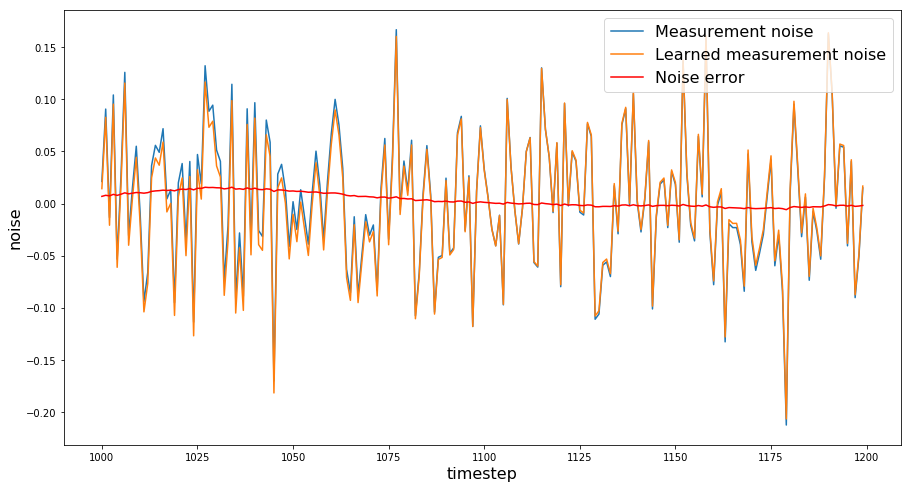

In [11]:
#plot learned and true noise of the given data in interval [start,end]
start = 1000
end = 1200
Nhat = K.eval(custom_loss.N_variable)

figure(figsize = (15,8))
plot(np.arange(200)+1000,measurement_noise.T[start:end,1], label = 'Measurement noise')
plot(np.arange(200)+1000,Nhat[start:end,1], label = 'Learned measurement noise')
plot(np.arange(200)+1000,measurement_noise.T[start:end,1] - Nhat[start:end,1], 'r', label = 'Noise error')
legend(loc='upper right', fontsize = 16)

xlabel('timestep', fontsize = 16)
ylabel('noise', fontsize = 16)

##### Compute error measures

In [12]:
x = X[:,0]; y = X[:,1]
#compute the true vector field
true_vector_field = np.stack([-0.1*x**3 + 2.0*y**3, -2.0*x**3 - 0.1*y**3], axis = 0)
#compute the learned vector field of the true states
approx_vec_field = model.predict(X, steps=1).T

#compute E_f 
noise_error = np.linalg.norm(measurement_noise.T - Nhat,'fro')**2 / m
#compute E_N 
vector_field_error = np.linalg.norm(true_vector_field - approx_vec_field,'fro')**2 / np.linalg.norm(true_vector_field,'fro')**2
#compute E_F 
trajectory_error = np.linalg.norm(X-X_test,'fro')**2 / np.linalg.norm(X,'fro')**2

#print error measures
print(noise_error)
print(vector_field_error)
print(trajectory_error)

0.00022384009234743867
0.012228589149532612
0.4640416438082419
